# VAE

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GioBonvi/MachineLearning/blob/main/VAE/VAE.ipynb)

This notebook demonstrates how to train a Variational Autoencoder (VAE) ([1](https://arxiv.org/abs/1312.6114), [2](https://arxiv.org/abs/1401.4082)) on the MNIST dataset. A VAE is a probabilistic take on the autoencoder, a model which takes high dimensional input data and compresses it into a smaller representation. Unlike a traditional autoencoder, which maps the input onto a latent vector, a VAE maps the input data into the parameters of a probability distribution, such as the mean and variance of a Gaussian. This approach produces a continuous, structured latent space, which is useful for image generation.

## Imports and variables

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Notebook variables.

image_shape = (28, 28, 1)
latent_dim = 2
epochs = 30
batch_size = 128
gif_file = "training_progress.gif"
progress_folder = "progress"
progress_filename = "epoch_{:04d}.png"
# Try changing the seed and see how the results change.
seed = 1

In [ ]:
# Setup

# Create all the necessary directories.
Path(progress_folder).mkdir(exist_ok=True, parents=True)
progress_file_path = os.path.join(progress_folder, progress_filename)

# Seed all the random generators, for reproducibility.
tf.random.set_seed(seed)
np.random.seed(seed)

# Required to embed the GIF in a Google Colab Notebook
from IPython.core.interactiveshell import InteractiveShell
from IPython import display as ipythondisplay
InteractiveShell.ast_node_interactivity = "all"

## The model

In this VAE example, use two small ConvNets for the encoder and decoder networks. In the literature, these networks are also referred to as inference/recognition and generative models respectively. Use `tf.keras.Sequential` to simplify implementation. Let $x$ and $z$ denote the observation and latent variable respectively in the following descriptions.

### Encoder network
This defines the approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation $z$. 
In this example, simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. 
Output log-variance instead of the variance directly for numerical stability.

### Decoder network 
This defines the conditional distribution of the observation $p(x|z)$, which takes a latent sample $z$ as input and outputs the parameters for a conditional distribution of the observation.
Model the latent distribution prior $p(z)$ as a unit Gaussian.

### Reparameterization trick
To generate a sample $z$ for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation $x$.
However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, use a reparameterization trick.
In our example, you approximate $z$ using the decoder parameters and another parameter $\epsilon$ as follows:

$$z = \mu + \sigma \odot \epsilon$$

where $\mu$ and $\sigma$ represent the mean and standard deviation of a Gaussian distribution respectively. They can be derived from the decoder output. The $\epsilon$ can be thought of as a random noise used to maintain stochasticity of $z$. Generate $\epsilon$ from a standard normal distribution.

The latent variable $z$ is now generated by a function of $\mu$, $\sigma$ and $\epsilon$, which would enable the model to backpropagate gradients in the encoder through $\mu$ and $\sigma$ respectively, while maintaining stochasticity through $\epsilon$.

### Network architecture
For the encoder network, use two convolutional layers followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

### Loss function

The loss function is defined as the sum of two components:

- The reconstruction loss is a simple binary crossentropy loss between the input and reconstructed image.
- The [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) evaluates the "distance" between two distributions. In this case we are using it to compare the distribution of each latent variable and a normal distribution. The loss is higher when the distribution differ more, "pushing" the latent variables towards normal distributions.

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, z_mean, z_log_var):
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # Reparametrization.
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def get_encoder():
  encoder_inputs = keras.Input(shape=image_shape)
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
  x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="relu")(x)
  z_mean = layers.Dense(latent_dim, name="z_mean")(x)
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()(z_mean, z_log_var)

  encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
  return encoder


def get_decoder():
    latent_inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 32, activation="relu")(latent_inputs)
    x = layers.Reshape((7, 7, 32))(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
    x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    return decoder

encoder = get_encoder()
decoder = get_decoder()

encoder.summary()
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 7, 7, 32)     9248        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 1568)         0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
  
class CaptureProgressImage(keras.callbacks.Callback):

    def __init__(self, model, test_sample, file_path):
        super().__init__()
        self.file_path = file_path
        self.model = model
        self.test_sample = test_sample

    def on_epoch_end(self, epoch, logs=None):
        self.generate_and_save_images(epoch)

    def generate_and_save_images(self, epoch):
        predictions = self.model.decoder(self.test_sample)
        
        fig = plt.figure(figsize=(4, 4))
        for i in range(predictions.shape[0]):
          plt.subplot(4, 4, i + 1)
          plt.imshow(predictions[i, :, :, 0], cmap='gray')
          plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig(self.file_path.format(epoch))
        plt.show()

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. Model each pixel with a Bernoulli distribution in our model, and statically binarize the dataset.

In [ ]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], *image_shape)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = preprocess_images(mnist_digits)
mnist_labels = np.concatenate([y_train, y_test], axis=0)

## Train

During training the `CaptureProgressImage` callback is called at the end of each epoch, sampling the latent space and returning a graphical representation.

Epoch 1/30
547/547 [==============================] - 10s 16ms/step - loss: 271.6693 - reconstruction_loss: 213.4793 - kl_loss: 1.7289


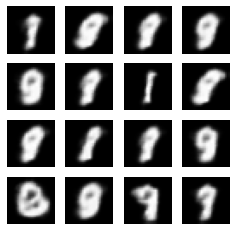

Epoch 2/30
547/547 [==============================] - 9s 16ms/step - loss: 172.0119 - reconstruction_loss: 164.2329 - kl_loss: 4.6793


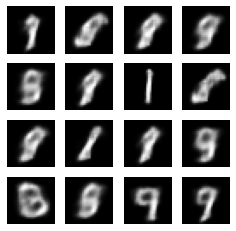

Epoch 3/30
547/547 [==============================] - 9s 16ms/step - loss: 162.2264 - reconstruction_loss: 156.1731 - kl_loss: 5.2585


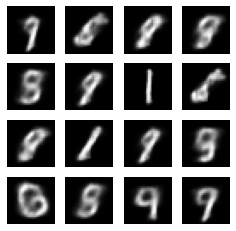

Epoch 4/30
547/547 [==============================] - 9s 16ms/step - loss: 159.1409 - reconstruction_loss: 152.8441 - kl_loss: 5.4911


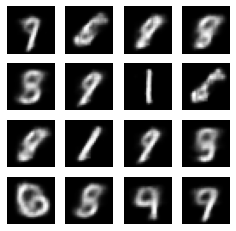

Epoch 5/30
547/547 [==============================] - 9s 16ms/step - loss: 156.8161 - reconstruction_loss: 150.8450 - kl_loss: 5.6391


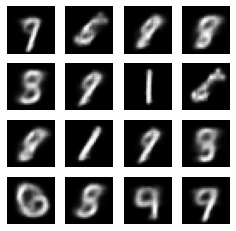

Epoch 6/30
547/547 [==============================] - 9s 17ms/step - loss: 155.5570 - reconstruction_loss: 149.4490 - kl_loss: 5.7166


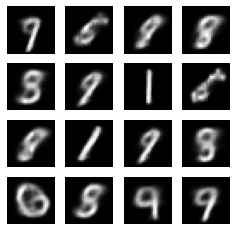

Epoch 7/30
547/547 [==============================] - 9s 16ms/step - loss: 154.4660 - reconstruction_loss: 148.2217 - kl_loss: 5.8373


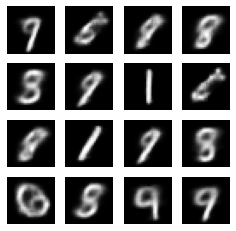

Epoch 8/30
547/547 [==============================] - 9s 17ms/step - loss: 153.3363 - reconstruction_loss: 147.3449 - kl_loss: 5.9225


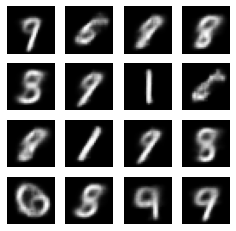

Epoch 9/30
547/547 [==============================] - 9s 17ms/step - loss: 152.7373 - reconstruction_loss: 146.5137 - kl_loss: 5.9600


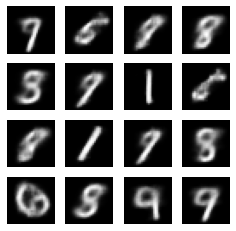

Epoch 10/30
547/547 [==============================] - 9s 17ms/step - loss: 152.1195 - reconstruction_loss: 145.9443 - kl_loss: 6.0215


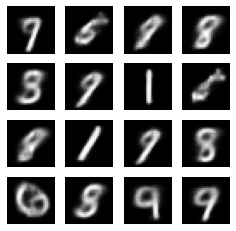

Epoch 11/30
547/547 [==============================] - 9s 17ms/step - loss: 151.7456 - reconstruction_loss: 145.4883 - kl_loss: 6.0349


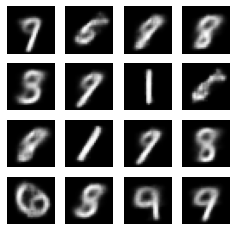

Epoch 12/30
547/547 [==============================] - 9s 17ms/step - loss: 151.1029 - reconstruction_loss: 144.8672 - kl_loss: 6.0672


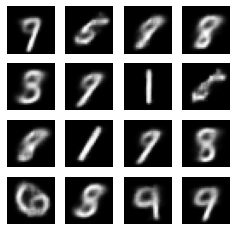

Epoch 13/30
547/547 [==============================] - 9s 17ms/step - loss: 150.6030 - reconstruction_loss: 144.4659 - kl_loss: 6.0785


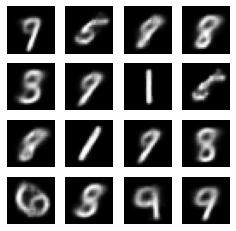

Epoch 14/30
547/547 [==============================] - 9s 17ms/step - loss: 150.3385 - reconstruction_loss: 144.0654 - kl_loss: 6.1054


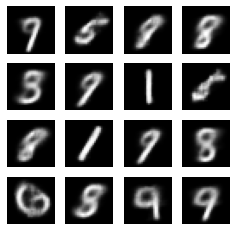

Epoch 15/30
547/547 [==============================] - 9s 17ms/step - loss: 149.7014 - reconstruction_loss: 143.7549 - kl_loss: 6.1088


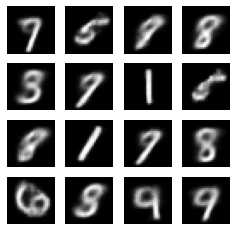

Epoch 16/30
547/547 [==============================] - 10s 18ms/step - loss: 149.6194 - reconstruction_loss: 143.2513 - kl_loss: 6.1081


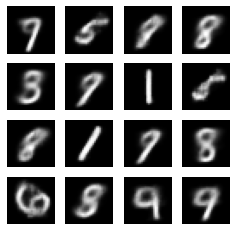

Epoch 17/30
547/547 [==============================] - 10s 18ms/step - loss: 148.9530 - reconstruction_loss: 142.9583 - kl_loss: 6.1459


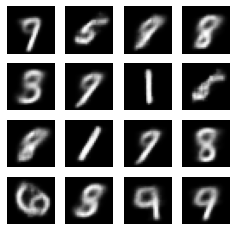

Epoch 18/30
547/547 [==============================] - 10s 18ms/step - loss: 148.7350 - reconstruction_loss: 142.6112 - kl_loss: 6.1537


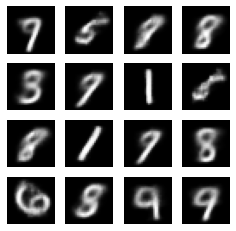

Epoch 19/30
547/547 [==============================] - 10s 18ms/step - loss: 148.9425 - reconstruction_loss: 142.5224 - kl_loss: 6.1591


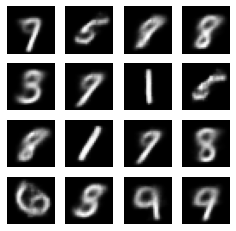

Epoch 20/30
547/547 [==============================] - 10s 18ms/step - loss: 148.2284 - reconstruction_loss: 142.1066 - kl_loss: 6.1656


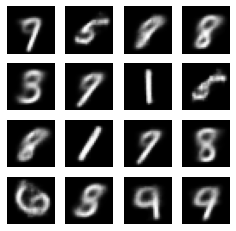

Epoch 21/30
547/547 [==============================] - 10s 18ms/step - loss: 148.2808 - reconstruction_loss: 141.9422 - kl_loss: 6.1810


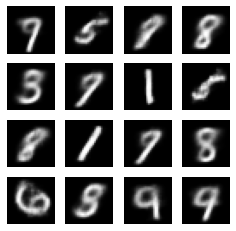

Epoch 22/30
547/547 [==============================] - 10s 18ms/step - loss: 148.3297 - reconstruction_loss: 141.7573 - kl_loss: 6.1956


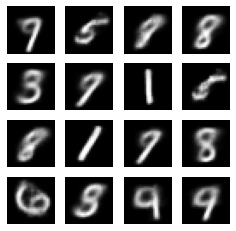

Epoch 23/30
547/547 [==============================] - 10s 18ms/step - loss: 147.9539 - reconstruction_loss: 141.5682 - kl_loss: 6.1957


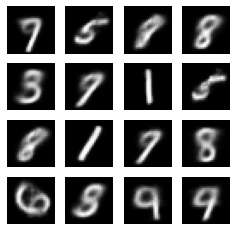

Epoch 24/30
547/547 [==============================] - 10s 18ms/step - loss: 147.3248 - reconstruction_loss: 141.3190 - kl_loss: 6.2013


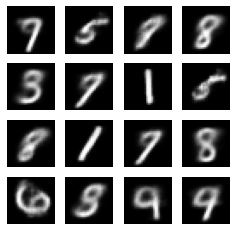

Epoch 25/30
547/547 [==============================] - 10s 18ms/step - loss: 147.4685 - reconstruction_loss: 141.2110 - kl_loss: 6.2046


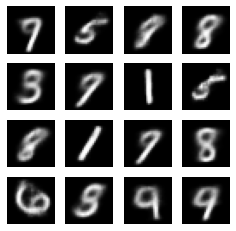

Epoch 26/30
547/547 [==============================] - 10s 18ms/step - loss: 147.2163 - reconstruction_loss: 141.0012 - kl_loss: 6.2315


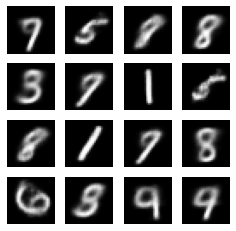

Epoch 27/30
547/547 [==============================] - 10s 18ms/step - loss: 146.9605 - reconstruction_loss: 140.8810 - kl_loss: 6.2333


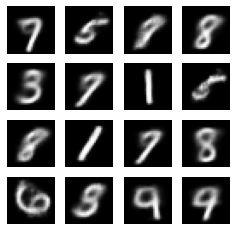

Epoch 28/30
547/547 [==============================] - 10s 18ms/step - loss: 147.1335 - reconstruction_loss: 140.6953 - kl_loss: 6.2366


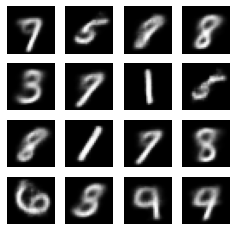

Epoch 29/30
547/547 [==============================] - 10s 18ms/step - loss: 146.6660 - reconstruction_loss: 140.5177 - kl_loss: 6.2606


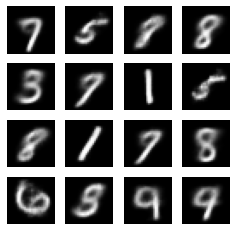

Epoch 30/30
547/547 [==============================] - 10s 18ms/step - loss: 146.5005 - reconstruction_loss: 140.3718 - kl_loss: 6.2578


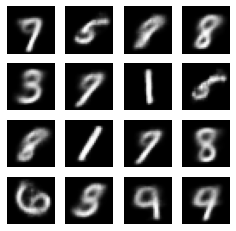

In [ ]:
num_examples_to_generate = 16
# Using the same random vector to generate the outputs of all epochs shows the progress.
random_vector_for_generation = tf.random.normal(shape=[num_examples_to_generate, latent_dim])

vae = VAE(encoder, decoder)
optimizer = keras.optimizers.Adam()
vae.compile(optimizer=optimizer)
capture_progress_image = CaptureProgressImage(vae, random_vector_for_generation, progress_file_path)
vae.fit(mnist_digits, epochs=epochs, batch_size=batch_size, callbacks=[capture_progress_image])

## Output

The images collected can then be used to create an animation showing the training progress.

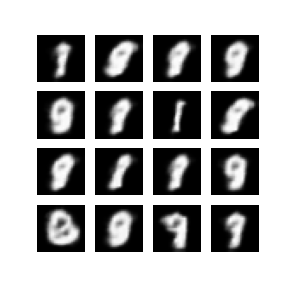

In [ ]:
# Create and save the GIF.
with imageio.get_writer(gif_file, mode='I') as writer:
  filenames = glob.glob(os.path.join(progress_folder, '*.png'))
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

# Show the GIF.
with open(gif_file, 'rb') as f:
    ipythondisplay.Image(data=f.read(), format='png')

In a similar way a more extensive sampling of the latent space can be displayed.

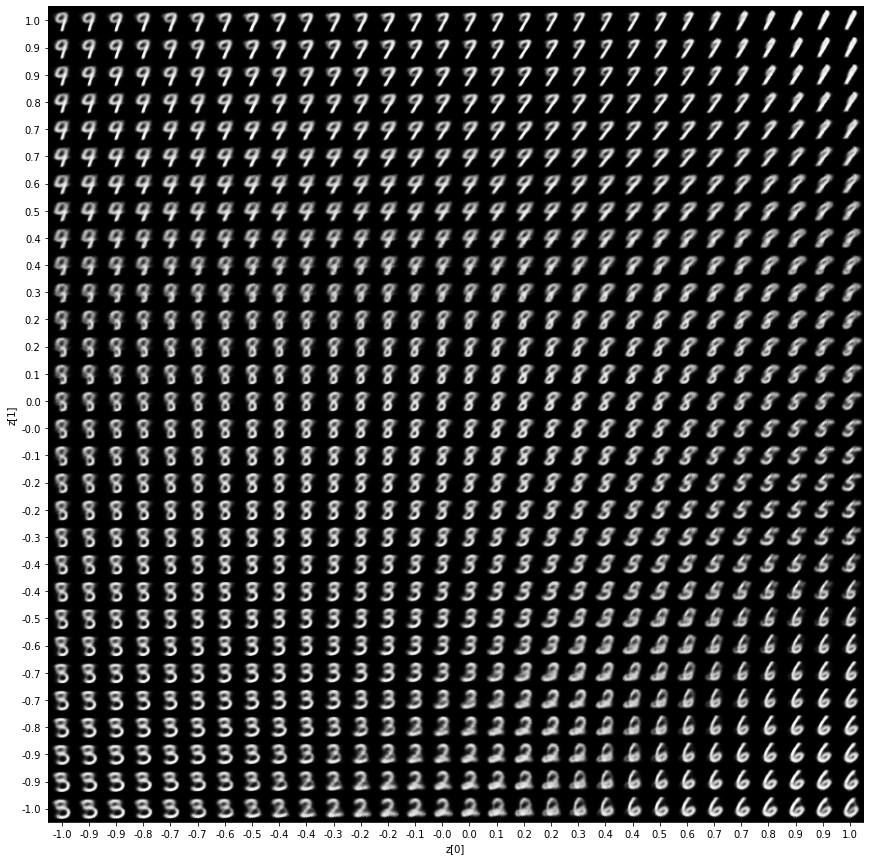

In [ ]:
def plot_latent_space(vae, scale=1.0, n=30, figsize=15):
    """Display a n*n 2D manifold of digits."""

    digit_size = image_shape[0]
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

Or even a representation showing where all digits were mapped to in the latent space. 

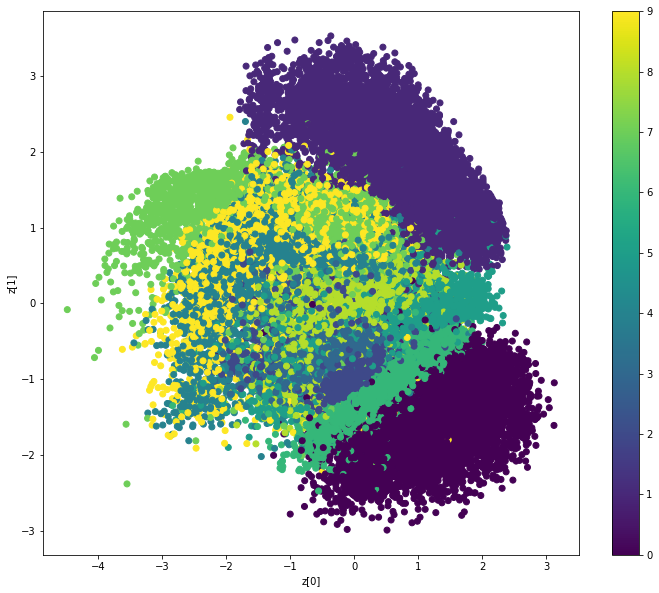

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


plot_label_clusters(vae, mnist_digits, mnist_labels)